<a href="https://colab.research.google.com/github/acse-ns1321/hirise_api_dev/blob/main/Autoencoder_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os,sys
from glob import glob
import cv2
os.environ['OPEgrid_columnsV_IO_ENABLE_JASPER'] = 'true'
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

from PIL import Image, ImageFile, ImageOps
from tqdm import tqdm
import random

Image.MAX_IMAGE_PIXELS = None
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Import torch packages that help us define our network
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset, random_split
import torchvision.transforms as transforms
from torchvision.transforms.transforms import Normalize
from torchvision import datasets, transforms, models

# Package that allows us to summarize our network
from torchsummary import summary

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
class Hirise_Image_Dataset(Dataset):
    """Hirise Image dataset."""
    def __init__(self,
                 path_to_images,
                 transform=None):
        # ------------------------------------------------------------------------------
        # path_to_images: where you put the image dataset
        # transform:  data transform
        # img_size: resize all images to a standard size
        # ------------------------------------------------------------------------------

        # Load all the images and their labels
        self.dataset = datasets.ImageFolder(path_to_images, transform=transform)
        self.len = len(self.dataset.imgs)
        self.path_to_images = path_to_images

        # ------------------------------------------------------------------------------
        # Split the data into train and test data 80 : 20
        # ------------------------------------------------------------------------------
        # Calculate the lengths of the vectors
        lengths = [int(np.ceil(len(self.dataset)*0.8)), int(np.floor(len(self.dataset)*0.2))]


        # Extract the images and labels   
        self.train_dataset, self.test_dataset = random_split(self.dataset, lengths)

    def __len__(self):
        # Return the number of samples
        return self.len

    def __getitem__(self, idx):
        sample, target = self.data[idx], self.data[idx]
        sample = sample.view(1, 256, 256).float()/255.
        if self.transform:
            sample = self.transform(sample)
            target = self.transform(target)
        return sample, target

In [4]:

class Data_Preparation:
    """Class that allows for data prepartion as part of the preprocessing of the hirise images. """
    def remove_background(self,file_name):
        src = cv2.imread(file_name, 1)
        tmp = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)
        _,alpha = cv2.threshold(tmp,0,255,cv2.THRESH_BINARY)
        b, g, r = cv2.split(src)
        rgba = [b,g,r, alpha]
        dst = cv2.merge(rgba,4)
        if np.allclose(np.asarray(dst), 0):
            os.remove(file_name)
        else:
            cv2.imwrite(file_name, dst)

    def resize_image(self, folder_path, resized_images_folder_path, pixel_length_cm = 250):
        reduce_factor = 25/pixel_length_cm
        imgfiles = glob(f"{folder_path}/*.IMG")

        # Convert to PIL Imgae
        img_list = []
        for img in tqdm(imgfiles):
            img_list.append(Image.open(img))

        if os.path.isdir(resized_images_folder_path):
            os.chdir(resized_images_folder_path)
        else:
            os.makedirs(resized_images_folder_path)
            os.chdir(resized_images_folder_path)

        for im,name in tqdm(zip(img_list,imgfiles)):         
            resized_im = im.resize((round(im.size[0]*reduce_factor), round(im.size[1]*reduce_factor)))
            try:
              resized_im.save(name.split('/')[-1]+'_resizedimage.jpg')
            except:
              pass
            
    def tile_images(self, folder_path,image_directory, image_size_pixels, resized = True,remove_background = True):
        if resized:
            imgfiles = glob(f"{folder_path}/*.jpg")
        else:
            imgfiles = glob(f"{folder_path}/*.IMG")
        # Convert to PIL Imgae
        img_list = []
        for img in imgfiles:
            img_list.append(Image.open(img))

        if os.path.isdir(image_directory):
            os.chdir(image_directory)
        else:
            os.makedirs(image_directory)
            os.chdir(image_directory)

        for img,name in tqdm(zip(img_list,imgfiles)):
            try:
                im = np.asarray(img)
                for r in range(0,math.ceil(im.shape[0]),image_size_pixels):
                    for c in range(0,math.ceil(im.shape[1]),image_size_pixels):
                            f_name = name.split('/')[-1].split('.')[0] + f"_{r}_{c}.jpg"
                            cv2.imwrite(str(f_name), im[r:r+image_size_pixels, c:c+image_size_pixels,:] )
                            if remove_background:
                                Data_Preparation.remove_background(self,file_name =f_name)
            except:
                pass                

        # sys.path.insert(0, parent_dir_path)

    def convert_to_grayscale(self, folder_path,image_directory, remove_background = True):
        imgfiles = glob(f"{folder_path}/*.jpg")

        im_list = []
        # Convert to PIL Imgae
        for img in imgfiles:
            im_list.append(cv2.imread(img, 1))
        
        if os.path.isdir(image_directory):
            os.chdir(image_directory)
        else:
            os.makedirs(image_directory)
            os.chdir(image_directory)

        for img,name in zip(im_list,imgfiles):
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            f_name = "gray_" + name.split('\\')[1]
            try:
                cv2.imwrite(f_name, gray)
            except:
                pass
            if remove_background:
                Data_Preparation.remove_background(self,file_name =f_name)
        # sys.path.insert(0, parent_dir_path)

    def remove_image_with_empty_pixels(self, folder_path, max_percentage_empty_space = 20):
        imgfiles = glob(f"{folder_path}/*.jpg")

        if os.path.isdir(folder_path):
            os.chdir(folder_path)
        else:
            print("ERROR!!")

        for f_name in tqdm(imgfiles):
            empty = 0
            img = Image.open(f_name.split('\\')[1])
            width, height = img.width, img.height
            total = width * height
            for pixel in img.getdata():
                if pixel == (0,0,0,0) or pixel == (0,0,0):            
                    empty += 1
            percent = round((empty * 100.0/total),1)
            if(percent >= max_percentage_empty_space):            
                os.remove(f_name.split('\\')[1])
        # sys.path.insert(0, parent_dir_path)

    def get_image_dataset(self,f_path,  transform_data =  None ):
        if not transform_data:
            transform_data = transforms.Compose([transforms.ToTensor()])
        # transform_data= transforms.Compose([transforms.ToTensor(), transforms.Grayscale(num_output_channels=1)])
        dataset = Hirise_Image_Dataset(path_to_images = f_path, transform = transform_data)

        return dataset

    def get_train_test_val_tensors(self, dataset):
            m=len(dataset.train_dataset)

            train_ds, val_ds = random_split(dataset.train_dataset, [math.floor(m-m*0.2), math.ceil(m*0.2)])
            # ------------------Training Data ----------------------------------------------
            # Empty lists to store the training data
            train_list = []
            # Append from the MedicalMNIST Object the training target and labels
            for data in train_ds:
                train_list.append(data[0])

            train_tensor = torch.Tensor(len(train_list))
            try :
                torch.cat(train_list,out = train_tensor)
            except :
                pass
            # ------------------- --- Test Data ---------------------------------------------
            # Empty lists to store the test data
            test_list = []
            for data in dataset.test_dataset:
                test_list.append(data[0])

            test_tensor = torch.Tensor(len(test_list))
            try:
                torch.cat(test_list,out = test_tensor)
            except :
                pass
            # ------------------- --- Val Data ---------------------------------------------
            # Empty lists to store the test data
            val_list = []
            for data in val_ds:
                val_list.append(data[0])

            val_tensor = torch.Tensor(len(val_list))

            try:
                torch.cat(val_list,out = val_tensor)
            except :
                pass
            return  train_tensor, test_tensor, val_tensor

    def get_train_test_val_dataloader(self, train_data, test_data, val_data,  b_size = 128):
        # Create TorchTensor Datasets containing training_data, testing_data, validation_data
        training_data = TensorDataset(train_data,train_data.long() )
        validation_data = TensorDataset(val_data,val_data.long() )
        testing_data = TensorDataset(test_data, test_data.long())
        train_loader = DataLoader(dataset = training_data, batch_size=b_size)
        valid_loader = DataLoader(dataset = validation_data, batch_size=b_size)
        test_loader = DataLoader(dataset = testing_data, batch_size=b_size,shuffle=True)
        return train_loader,  test_loader, valid_loader

    def show_training_data(self, dataset, grid_rows=5, grid_columns=5):
        """ Prints the traning data in a grid"""
        # Set up axes and subplots
        fig, axarr = plt.subplots(grid_rows, grid_columns, figsize=(10, 10))

        # Loops to run over the grid
        for i in range(grid_rows):
            for j in range(grid_columns):

                # Generate a random index in the training dataset
                idx = random.randint(0, len(dataset.train_dataset))

                # Get the sample and target fromthe traiig datasets
                sample, target  = dataset.train_dataset[idx]

                try:
                    # Exception handling - if it is PIL
                    axarr[i][j].imshow(sample, cmap = "gray")
                except:
                    # If tensor of shape CHW
                    axarr[i][j].imshow(sample.permute(1,2,0), cmap = "gray") 
                # Get the classes of the target data
                target_name = dataset.dataset.targets[target]
                # Label each image eith the target name and the class it belongs to
                axarr[i][j].set_title("%s (%i)"%(target_name, target))
        # Deine the grid layout and padding
        
        fig.tight_layout(pad=1)
        plt.show()

In [7]:


class CAE_Encoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            # First convolutional layer
            nn.Conv2d(1, 8, kernel_size= 3, stride=2, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            # Second convolutional layer
            nn.Conv2d(8, 16, kernel_size= 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            # Third convolutional layer
            nn.Conv2d(16, 32, kernel_size= 3, stride=2, padding=0),
            nn.BatchNorm2d(32),
            nn.ReLU(True)
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)

        ### Linear section
        self.encoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(31*31*32, 1024),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(1024, encoded_space_dim)
        )
        
    def forward(self, x):
        # Apply convolutions
        x = self.encoder_cnn(x)
        # Flatten
        x = self.flatten(x)
        # # Apply linear layers
        x = self.encoder_lin(x)
        return x

device = 'cuda'
# Dummy input of the same size as the Medical-MNIST images
x = torch.randn(1,1,256,256).to(device) 

# Instantiate the model
model = CAE_Encoder(encoded_space_dim=40,fc2_input_dim=256).to(device)

y = model(x) 
print(model)
print(x.shape, y.shape)

# Show the summary of the outputs and parameters of each layer
summary(model, input_size = (1,256,256))

CAE_Encoder(
  (encoder_cnn): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (encoder_lin): Sequential(
    (0): Linear(in_features=30752, out_features=1024, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=1024, out_features=40, bias=True)
  )
)
torch.Size([1, 1, 256, 256]) torch.Size([1, 40])
----------------------------------------------------------------
        Layer (type)               Output Shape 

In [8]:

class CAE_Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()

        ### Linear section
        self.decoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(encoded_space_dim, 1024),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(1024,31*31*32),
            nn.ReLU(True)
        )

        ### Unflatten
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 31, 31))

        ### Convolutional section
        self.decoder_conv = nn.Sequential(
            # First transposed convolution
            nn.ConvTranspose2d(32, 16,kernel_size= 3, stride=2,output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            # Second transposed convolution
            nn.ConvTranspose2d(16, 8, kernel_size= 3, stride=2, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            # Third transposed convolution
            nn.ConvTranspose2d(8, 1,  kernel_size= 3, stride=2,padding=1,output_padding=1)
        )
        
    def forward(self, x):
        # Apply linear layers
        x = self.decoder_lin(x)
        # Unflatten
        x = self.unflatten(x)
        # Apply transposed convolutions
        x = self.decoder_conv(x)
        # Apply a sigmoid to force the output to be between 0 and 1 (valid pixel values)
        x = torch.sigmoid(x)
        return x


In [96]:

batch_size = 64

loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr= 0.5e-3

### Set the random seed for reproducible results
torch.manual_seed(0)

### Initialize the two networks
d = 100

#model = Autoencoder(encoded_space_dim=encoded_space_dim)
encoder = CAE_Encoder(encoded_space_dim=d,fc2_input_dim=256)
decoder = CAE_Decoder(encoded_space_dim=d,fc2_input_dim=256)
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)



Selected device: cuda


CAE_Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=100, out_features=1024, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=1024, out_features=30752, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 31, 31))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), output_padding=(1, 1))
    (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

In [123]:

folder_path = '/content/drive/MyDrive/Images/sup-images/'
diz_loss = {'train_loss':[],'val_loss':[]}
transform1= transforms.Compose([transforms.ToTensor(), transforms.Resize((256, 256)),transforms.Normalize(0.40655,0.1159), transforms.Grayscale(num_output_channels=1)])
# transform1= transforms.Compose([transforms.ToTensor(), transforms.Resize((256, 256)),transforms.Grayscale(num_output_channels=1)])

dp = Data_Preparation()

dataset1 = dp.get_image_dataset(f_path = folder_path, transform_data = transform1)
tr,tst,val = dp.get_train_test_val_tensors(dataset = dataset1)
train_loader,test_loader, val_l = dp.get_train_test_val_dataloader(tr,tst,val)

In [139]:
dataset1.dataset.class_to_idx

{'eolian': 0, 'fluvial': 1, 'impact': 2, 'rocks': 3, 'volcanic': 4}

In [124]:
print("Mean",torch.mean(tr))
print("Std",torch.std(tr))

Mean tensor(0.2178)
Std tensor(1.1015)


In [125]:
img, _ = dataset1.train_dataset[0]
img = img.unsqueeze(0).to(device) # Add the batch dimension in the first axis
print('Original image shape:', img.shape)


img_enc = encoder(img)
print('Encoded image shape:', img_enc.shape)

# Decode the image
dec_img = decoder(img_enc)
#dec_img = model(img)
print('Decoded image shape:', dec_img.shape)

Original image shape: torch.Size([1, 1, 256, 256])
Encoded image shape: torch.Size([1, 100])
Decoded image shape: torch.Size([1, 1, 256, 256])


In [126]:
### Training function
def train_CAE(encoder, decoder, device, dataloader, loss_fn, optimizer):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    train_loss = []
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch, _ in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        image_batch = image_batch.to(device)
        # Encode data
        encoded_data = encoder(image_batch)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        loss = loss_fn(decoded_data, image_batch)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        print('\t partial train loss (single batch): %f' % (loss.data))
        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)
      ### Training function
### Training function
def train_batchs(encoder, decoder, device, dataloader, loss_fn, optimizer):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    train_loss = []
  # Initialize the training loss and training accuracy
    train_accuracy = 0
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch, _ in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        image_batch = image_batch.unsqueeze(0).permute(1,0,2,3)
        # Move tensor to the proper device
        image_batch = image_batch.to(device)
        # Encode data
        encoded_data = encoder(image_batch)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        loss = loss_fn(decoded_data, image_batch)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        print('\t partial train loss (single batch): %f' % (loss.data))
        train_loss.append(loss.detach().cpu().numpy())

 # Train Accuracy
    return np.mean(train_loss)


def test_batchs(encoder, decoder, device, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        output_list = []
        label_list = []
        for image_batch, _ in dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.unsqueeze(0).permute(1,0,2,3)
            image_batch = image_batch.to(device)
            # Encode data
            encoded_data = encoder(image_batch)
            # Decode data
            decoded_data = decoder(encoded_data)
            # Append the network output and the original image to the lists
            output_list.append(decoded_data.cpu())
            label_list.append(image_batch.cpu())
        # Create a single tensor with all the values in the lists
        output_list = torch.cat(output_list)
        label_list = torch.cat(label_list) 
        # Evaluate global loss
        val_loss = loss_fn(output_list, label_list)
    return val_loss.data
  


def plot_autoencoder_results(encoder,decoder,n=5):
    plt.figure(figsize=(10,4.5))
    for i in range(n):
      ax = plt.subplot(2,n,i+1)
      img = dataset1.train_dataset[i][0].unsqueeze(0).to(device)
      encoder.eval()
      decoder.eval()
      with torch.no_grad():
         rec_img  = decoder(encoder(img))
      plt.imshow(img.cpu().squeeze().numpy(), cmap='gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gray')  
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.show()

In [127]:
# decoder.save_weights('decoder.h5')
# decoder_json = decoder.to_json()
# with open('decoder.json', 'w') as json_file:
#     json_file.write(decoder_json)
# !pip install livelossplot

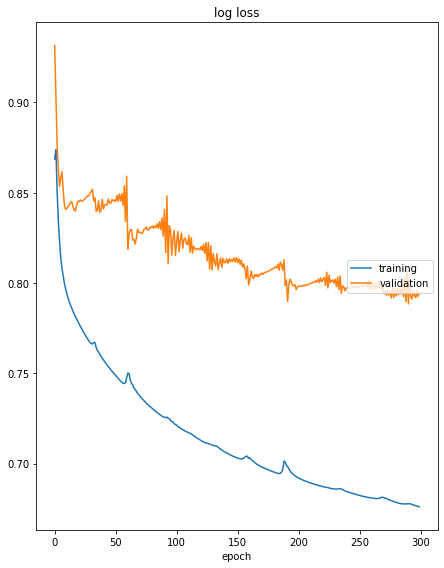

log loss
	training         	 (min:    0.676, max:    0.874, cur:    0.676)
	validation       	 (min:    0.788, max:    0.932, cur:    0.795)


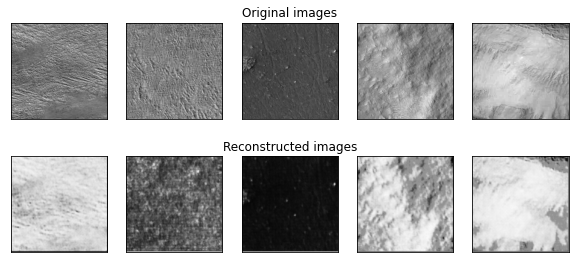

In [128]:
# Import Plotting packages 
from livelossplot import PlotLosses
num_epochs = 300
diz_loss = {'train_loss':[],'val_loss':[]}

liveloss = PlotLosses()
for epoch in range(num_epochs):
   # Save the logs in a dict
    logs = {}


    # Arrays to store loss and accuracy of each iteration during test
    tr_accuracy = []
    tr_loss = []
    vl_loss = []
    vl_accuracy = []

    train_loss =train_batchs(encoder,decoder,device,train_loader,loss_fn,optim)
    val_loss = test_batchs(encoder,decoder,device,test_loader,loss_fn)

    print('\n EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs,train_loss,val_loss))

    diz_loss['train_loss'].append(train_loss)
    diz_loss['val_loss'].append(val_loss)
    # plot_autoencoder_results(encoder,decoder,n=5)
    # Add training log loss and accuracy to the logs
    logs['' + 'log loss'] = train_loss.item()



    # Add validation log loss and accuracy to the logs
    logs['val_' + 'log loss'] = val_loss.item()


    # Update the liveloss with the logs
    liveloss.update(logs)
    liveloss.draw()

plot_autoencoder_results(encoder,decoder,n=5)


In [103]:
# !pip install livelossplot
# !pip install pycm

In [105]:
# dp = Data_Preparation()


In [106]:
# dp.resize_image(folder_path='/content/drive/MyDrive/data-download',resized_images_folder_path= '/content/drive/MyDrive/data-download/resized-images/',pixel_length_cm = 250)

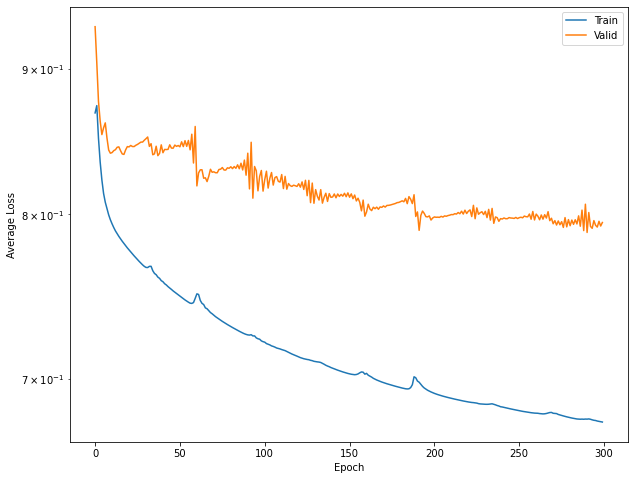

In [129]:
test_batchs(encoder,decoder,device,test_loader,loss_fn).item()# Plot losses
plt.figure(figsize=(10,8))
plt.semilogy(diz_loss['train_loss'], label='Train')
plt.semilogy(diz_loss['val_loss'], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
#plt.grid()
plt.legend()
#plt.title('loss')
plt.show()

In [164]:
encoded_samples_list = []
for sample in tqdm(dataset1.train_dataset):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    encoder.eval()
    with torch.no_grad():
        encoded_img  = encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples_list.append(encoded_sample)
encoded_samples = pd.DataFrame(encoded_samples_list)
encoded_samples

100%|██████████| 196/196 [00:01<00:00, 120.82it/s]


,Enc. Variable 0,Enc. Variable 1,Enc. Variable 2,Enc. Variable 3,Enc. Variable 4,Enc. Variable 5,Enc. Variable 6,Enc. Variable 7,Enc. Variable 8,Enc. Variable 9,...,Enc. Variable 91,Enc. Variable 92,Enc. Variable 93,Enc. Variable 94,Enc. Variable 95,Enc. Variable 96,Enc. Variable 97,Enc. Variable 98,Enc. Variable 99,label
0,2.735104,-2.750975,-0.676249,-3.475925,-2.494931,-6.834416,-0.093996,0.673671,-0.612263,4.827831,...,-1.909864,2.611729,2.684868,-1.487982,-2.457701,-3.706768,4.199088,2.398494,-1.417323,0
1,5.156925,-0.148554,-5.404860,1.313323,1.898839,-0.880099,-2.092101,-3.867815,-0.865239,2.927226,...,5.873347,1.310961,-2.283735,3.406304,1.911791,-6.864474,3.078236,-8.226609,3.115398,3
2,3.183278,1.209978,-6.956503,4.732740,3.837274,-5.847518,8.620613,-8.374301,-4.165547,6.260532,...,6.425171,3.353606,-5.100672,8.333364,-0.402396,-7.914608,5.644443,-14.538794,5.027361,0
3,3.621440,-0.526326,-2.565774,-5.022329,-1.597200,0.929457,-0.156087,-0.761509,0.690454,-1.461343,...,1.387530,-1.855687,-0.170072,-3.068952,-1.986511,1.174325,4.046554,-1.555505,0.345180,1
4,1.253581,1.435809,-2.004724,0.004456,-4.951363,0.607168,-2.546877,-0.692410,-0.304285,0.202484,...,-1.132359,-2.548360,2.133867,0.192131,0.800707,-1.169757,2.305617,-1.134570,-1.087065,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,4.955415,0.175056,-5.442908,1.994887,0.630884,-0.165110,-1.300876,-3.149219,0.080492,3.239688,...,6.408511,2.865438,-3.448026,3.459087,2.013296,-7.271441,2.435312,-9.035096,3.564627,3
192,13.894705,10.592420,2.730333,-3.113855,3.613704,-10.171659,1.057836,-6.448416,-8.349869,9.082947,...,7.882623,-4.881373,2.903916,-6.391226,2.041721,-10.674479,5.159448,-9.101871,-1.737044,4
193,8.062894,0.951959,-7.483336,0.849218,19.601454,-18.601835,12.823302,-7.529323,-19.065464,6.472147,...,-4.246894,-0.538380,5.380968,6.518752,-1.389764,-4.946779,12.197583,-10.852937,10.030400,0
194,4.789233,0.836840,-7.633925,4.014195,1.845686,-6.441471,6.972360,-11.964528,-2.423329,4.316840,...,7.861622,2.181036,-3.729573,10.253208,0.494055,-6.343596,5.856102,-13.953209,2.200735,0


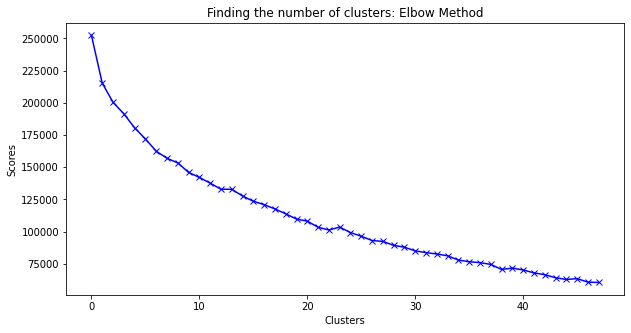

In [165]:
from sklearn.cluster import KMeans

np.random.seed(0)
inps = 50
ssd = []

for i in range(2, inps):
  km = KMeans(n_clusters= i).fit(encoded_samples)
  ssd.append(km.inertia_)

plt.figure(figsize = (10,5))
plt.plot(ssd, 'bx-')
plt.title('Finding the number of clusters: Elbow Method')
plt.xlabel('Clusters')
plt.ylabel('Scores') 
plt.show()


In [167]:
# plt.figure(figsize=(10,10))
# x = encoded_samples[:,0]
# y = encoded_samples[:,1]
# z = encoded_samples[:,2]
# ax = plt.axes(projection = '3d')
# ax.scatter(x,y,z,c=y,cmap='viridis',linewidth = 4)

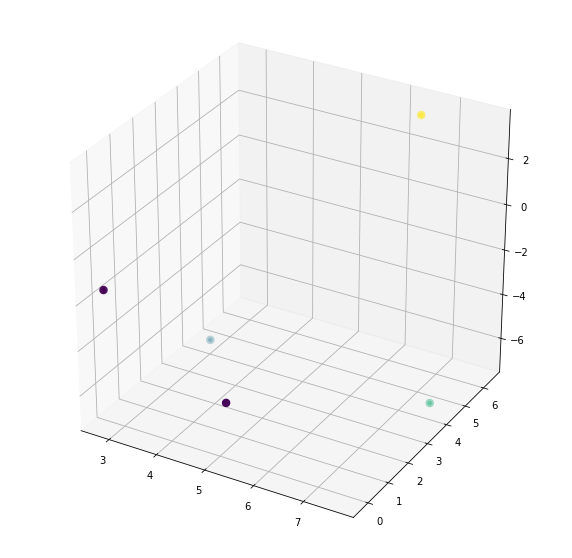

In [204]:
kmeans_encoded = KMeans(5)
kmeans_encoded.fit(encoded_samples)
centers = kmeans_encoded.cluster_centers_
k_labels = kmeans_encoded.labels_
y_kmeans = kmeans_encoded.fit_predict(encoded_samples)
plt.figure(figsize=(10,10))

x = centers[:,0]
y = centers[:,1]
z = centers[:,2]

ax = plt.axes(projection = '3d')
ax.scatter(x,y,z,c=y,cmap='viridis',linewidth = 4)

In [205]:
df_cluster = pd.concat([encoded_samples, pd.DataFrame({'cluster':k_labels})], axis = 1)
# df_cluster.head()
import plotly.express as px
# print(encoded_samples.label)
px.scatter(df_cluster, x='Enc. Variable 0', y='Enc. Variable 1',color = k_labels.astype(str) ,  opacity=1, title="After KMeans Clustering")

In [200]:

import plotly.express as px
# print(encoded_samples.label)
px.scatter(encoded_samples, x='Enc. Variable 0', y='Enc. Variable 1', 
           color=encoded_samples.label.astype(str), opacity=1, title="Latent Space Before Clustering")

In [140]:
dataset1.dataset.class_to_idx

{'eolian': 0, 'fluvial': 1, 'impact': 2, 'rocks': 3, 'volcanic': 4}

In [136]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(encoded_samples.drop(['label'],axis=1))
fig = px.scatter(tsne_results, x=0, y=1,
                 color=encoded_samples.label.astype(str),
                 labels={'0': 'tsne-2d-one', '1': 'tsne-2d-two'})
fig.show()

In [201]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(df_cluster.drop(['cluster'],axis=1))
fig = px.scatter(tsne_results, x=0, y=1,
                 color=encoded_samples.label.astype(str),
                 labels={'0': 'tsne-2d-one', '1': 'tsne-2d-two'})
fig.show()